## IS 362 Final Project
### By Alexander Doler
#### May 14, 2017


#### This project aims to analyze NBA player and team data, such as player salaries and individual stats, as well as team revenue and worth, in order to identify trends that affect players' salaries.

* Hypothesis prior to analyzing the data:
    * There will be a trend toward higher earnings for players with better stats
    * Players playing for teams with higher revenue will also earn more

In [66]:
import pandas as pd
import numpy as np
import html5lib
import decimal
import matplotlib.pyplot as plt
import json
import requests
import sqlite3
%matplotlib inline

### Import data

- Data is imported from 3 different sources.
    - Table scraped from web: **Player salaries**
    - Table scraped from web: **Player statistics**
    - CSV file converted to an SQLITE database and imported as a dataframe: **Team worth and revenue**
    


### Import scraped player salaries

In [67]:
source = 'http://espn.go.com/nba/salaries/_/page/'
SALARY_DATA = pd.read_html(source, header=None, skiprows=[0,11,22,33])
SALARY_DATA = SALARY_DATA[0]
SALARY_DATA.columns = ["Rank","Player","Team","Salary"]
SALARY_DATA.head()

,Rank,Player,Team,Salary
0,1,"LeBron James, SF",Cleveland Cavaliers,"$30,963,450"
1,2,"Mike Conley, PG",Memphis Grizzlies,"$26,540,100"
2,3,"Al Horford, C",Boston Celtics,"$26,540,100"
3,4,"Dirk Nowitzki, PF",Dallas Mavericks,"$25,000,000"
4,5,"Carmelo Anthony, SF",New York Knicks,"$24,559,380"


### Import scraped player statistics

In [68]:
sourceStats = 'http://www.basketball-reference.com/leagues/NBA_2016_totals.html'
STAT_DATA = pd.read_html(sourceStats)
STAT_DATA = STAT_DATA[0]
STAT_DATA.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Quincy Acy,PF,25,SAC,59,29,876,119,214,...,.735,65,123,188,27,29,24,27,103,307
1,2,Jordan Adams,SG,21,MEM,2,0,15,2,6,...,.600,0,2,2,3,3,0,2,2,7
2,3,Steven Adams,C,22,OKC,80,80,2014,261,426,...,.582,219,314,533,62,42,89,84,223,636
3,4,Arron Afflalo,SG,30,NYK,71,57,2371,354,799,...,.840,23,243,266,144,25,10,82,142,909
4,5,Alexis Ajinca,C,27,NOP,59,17,861,150,315,...,.839,75,194,269,31,19,36,54,134,352


### Import SQL database containing team value and revenue

In [69]:
"""
Commands to convert teamdata csv into SQLITE database:
- cat teamdata.csv | tr -s '\r' '\n' > teamdata2.csv
- sqlite3 teamdata.db
- .mode csv
- .import teamdata2.csv teamdata
"""

sql = '''SELECT "Team", "Current Value1 ($mil)", "Revenue3 ($mil)", "Operating Income4 ($mil)"
         FROM teamdata;
         '''
con = sqlite3.connect("teamdata.db")
TEAM_DATA = pd.read_sql_query(sql, con)
con.close()
TEAM_DATA.columns = ["Team","CurrValue","Revenue", "OperIncome"]
TEAM_DATA.head()

,Team,CurrValue,Revenue,OperIncome
0,Los Angeles Lakers,607,209,51.1
1,New York Knicks,586,202,21
2,Chicago Bulls,511,168,51
3,Detroit Pistons,479,171,46.9
4,Cleveland Cavaliers,476,159,5


#### The player salary data came with the player name and position in the same column. The algorithm below splits this column and creates two new columns; one for Player names and on for their Position

In [70]:
player = []
position = []

for cell in SALARY_DATA.Player:
    new = cell.split(',')
    player.append(new[0])
    position.append(new[1])
    
player = pd.Series(player)
position = pd.Series(position)

SALARY_DATA.Player = player
SALARY_DATA['Position'] = position
SALARY_DATA.head()

,Rank,Player,Team,Salary,Position
0,1,LeBron James,Cleveland Cavaliers,"$30,963,450",SF
1,2,Mike Conley,Memphis Grizzlies,"$26,540,100",PG
2,3,Al Horford,Boston Celtics,"$26,540,100",C
3,4,Dirk Nowitzki,Dallas Mavericks,"$25,000,000",PF
4,5,Carmelo Anthony,New York Knicks,"$24,559,380",SF


#### The salary column was not in a numeric format understood by pandas. I had to remove the dollar sign and commas and turn the column into a numeric (float) datatype.

#### I then calculate the mean salary for each position. As we can see, the point guard is the position with the highest average salary. This makes sense, as it is often regarded as the lead position on the court.

In [71]:
salaries = []

for salary in SALARY_DATA.Salary:
    salary = salary.strip("$")
    salary = salary.replace(",", "")
    salary = float(salary)
    salaries.append(salary)

pd.Series(salaries)

SALARY_DATA.Salary = salaries
    

SALARY_DATA.Salary.astype(np.float64)
SALARY_DATA.groupby("Position").mean().sort_values("Salary",ascending=False)

,Rank,Salary
Position,,
PG,15.833333,2.160943e+07
PF,17.777778,2.094496e+07
SF,21.000000,2.026861e+07
C,21.500000,2.004293e+07
SG,25.500000,1.898615e+07


#### Below is a graph of the same average salary per position data

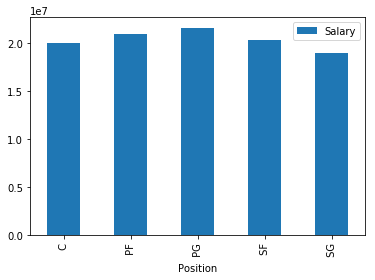

In [72]:
SALARY_DATA.groupby("Position").mean().plot(y="Salary",kind="bar")

#### In this cell I merge the Salary dataset with the Player Stats dataset. This is done via an "Inner" join on the Player columns.

In [84]:
MERGED_DF = SALARY_DATA.merge(STAT_DATA, how='inner', on='Player')
MERGED_DF.PTS = pd.to_numeric(MERGED_DF.PTS)
MERGED_DF.head()

,Rank,Player,Team,Salary,Position,Rk,Pos,Age,Tm,G,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,LeBron James,Cleveland Cavaliers,30963450.0,SF,221,SF,31,CLE,76,...,.731,111,454,565,514,104,49,249,143,1920
1,2,Mike Conley,Memphis Grizzlies,26540100.0,PG,93,PG,28,MEM,56,...,.834,26,138,164,342,67,16,84,100,857
2,3,Al Horford,Boston Celtics,26540100.0,C,207,C,29,ATL,82,...,.798,148,448,596,263,68,121,107,163,1249
3,4,Dirk Nowitzki,Dallas Mavericks,25000000.0,PF,332,PF,37,DAL,75,...,.893,52,437,489,132,52,52,84,161,1372
4,5,Carmelo Anthony,New York Knicks,24559380.0,SF,21,SF,31,NYK,72,...,.829,98,458,556,299,62,38,176,180,1573


#### Scatter plot showing the relationship between Salary and Points Scored
- As we can see, there is indeed a loose relationship between the two.
- There is a trend toward higher salaries for players who score more points, but it is not an extremely strong relationship, as some high scorers have low salaries.

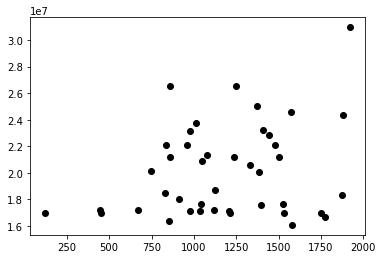

In [74]:
plt.scatter(MERGED_DF.PTS,MERGED_DF.Salary,c="black")


In [85]:
MERGED_DF = MERGED_DF.merge(TEAM_DATA, how='inner', on='Team')
MERGED_DF.head()

,Rank,Player,Team,Salary,Position,Rk,Pos,Age,Tm,G,...,TRB,AST,STL,BLK,TOV,PF,PTS,CurrValue,Revenue,OperIncome
0,1,LeBron James,Cleveland Cavaliers,30963450.0,SF,221,SF,31,CLE,76,...,565,514,104,49,249,143,1920,476,159,5
1,17,Kevin Love,Cleveland Cavaliers,21165675.0,PF,272,PF,27,CLE,77,...,762,186,58,41,142,159,1234,476,159,5
2,27,Kyrie Irving,Cleveland Cavaliers,17638063.0,PG,218,PG,23,CLE,53,...,157,249,56,18,124,107,1041,476,159,5
3,2,Mike Conley,Memphis Grizzlies,26540100.0,PG,93,PG,28,MEM,56,...,164,342,67,16,84,100,857,257,88,-7.1
4,11,Chandler Parsons,Memphis Grizzlies,22116750.0,SF,345,SF,27,DAL,61,...,285,169,46,21,95,114,837,257,88,-7.1


### Comparing team overall value to player salaries
- Based on the line graph below, there seems to be little correlation between team value and player salaries.
- There is correlation between ONLY the highest valued teams and the highest paid players, as demonstrated by the outlying portion on the left side of the graph.

In [77]:
COMPARE_TEAM_VALUES = MERGED_DF[["Player","Team","Salary","CurrValue"]].copy()
COMPARE_TEAM_VALUES.CurrValue = pd.to_numeric(MERGED_DF.CurrValue)
COMPARE_TEAM_VALUES.CurrValue = COMPARE_TEAM_VALUES.CurrValue * 100000

COMPARE_TEAM_VALUES_VALUE = COMPARE_TEAM_VALUES.groupby(["Team","Player"]).sum().reset_index().sort_values(["CurrValue","Team"], ascending=False).reset_index()
COMPARE_TEAM_VALUES_VALUE = COMPARE_TEAM_VALUES_VALUE.drop("index", 1)

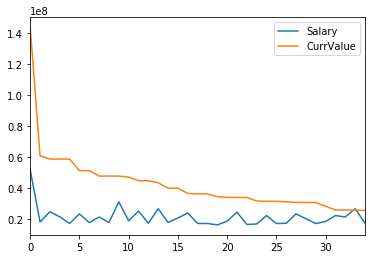

In [82]:
COMPARE_TEAM_VALUES_VALUE.plot()

### Comparing team revenue to player salaries
- Once again, the only correlation between team revenue and player salaries it between the outliers. There is a correlation between only the highest-revenue teams and highest-paid players.

In [78]:
COMPARE_TEAM_VALUES = MERGED_DF[["Player","Team","Salary","Revenue"]].copy()
COMPARE_TEAM_VALUES.Revenue = pd.to_numeric(MERGED_DF.Revenue)
COMPARE_TEAM_VALUES.Revenue = COMPARE_TEAM_VALUES.Revenue * 100000

COMPARE_TEAM_VALUES_REVENUE = COMPARE_TEAM_VALUES.groupby(["Team","Player"]).sum().reset_index().sort_values(["Revenue","Team"], ascending=False).reset_index()
COMPARE_TEAM_VALUES_REVENUE = COMPARE_TEAM_VALUES_REVENUE.drop("index", 1)

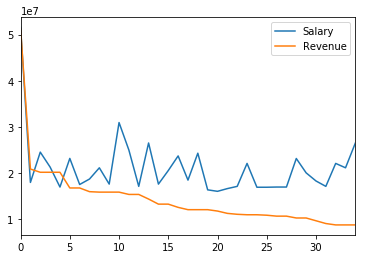

In [81]:
COMPARE_TEAM_VALUES_REVENUE.plot()

#### I investigated the PyGitHub API, which can be used to manage GitHub repos and commit files directly from a Python App. The API can be useful if you need to publish data to GitHub in realtime. An example could be website survey data, website usage stats, etc., that needs to be posted to GitHub in realtime periodically.

In [83]:
from github import Github
from github import Commit
g = Github("aedoler", "**********")

user = g.get_user()

new_repo = 'IS_362_Final_Project_PyGitHub'
for repo in g.get_user().get_repos():
    if not new_repo:
        repo = user.create_repo('IS_362_Final_Project_PyGitHub')
    elif repo.name == new_repo:
        print("Found repo: %s" % repo.name)


Found repo: IS_362_Final_Project_PyGitHub


## Conclusions
- There are some factors that affect how much an NBA player earns. Two of these are both the player's position and certain stats, such as points scored.
    - Point Guard is the position that tends to earn the most. Makes sense since they are often the leaders on the           court.
    - Shooting Guards have the lowest salary on average, with the remaining positions somewhere in between.
    - Players having scored more points tend to earn more. This is not an extremely strong relationship however, as         there are too many outliers.
- Team monetary value and revenue seems to have little to no impact on players' salaries- except in the case of players making the highest salaries and teams with the highest value/revenue.
